Daily rows: 1807 Period: 2010-01-02 00:00:00 -> 2014-12-31 00:00:00
Train samples: 1232 Test samples: 180

=== BASELINE ===
day+1  MAE=47.88 RMSE=68.42
day+2..30 MAE_avg=75.03 RMSE_avg=104.27 | MAE day+7=75.88 | MAE day+30=74.95

=== MODELS ===
HGB        day+1 MAE=43.91 RMSE=63.04 | day+2..30 MAE_avg=55.36 RMSE_avg=79.67 | MAE day+7=50.91 | MAE day+30=56.01
ExtraTrees day+1 MAE=41.28 RMSE=63.16 | day+2..30 MAE_avg=52.07 RMSE_avg=76.89 | MAE day+7=50.27 | MAE day+30=52.82
Ridge      day+1 MAE=43.77 RMSE=65.65 | day+2..30 MAE_avg=52.89 RMSE_avg=77.84 | MAE day+7=50.30 | MAE day+30=53.91


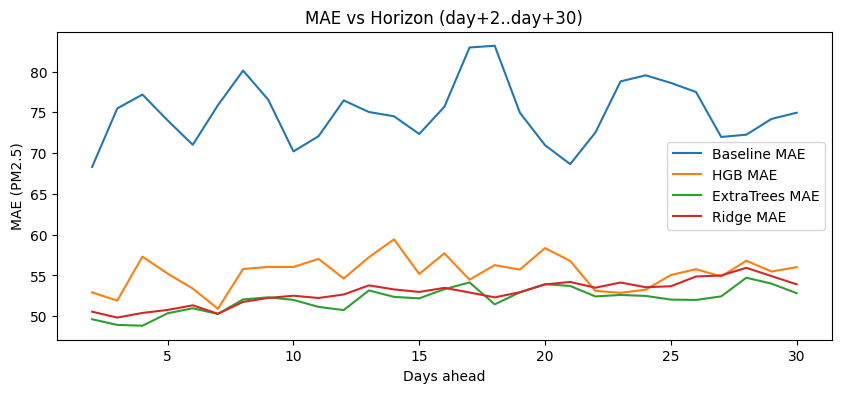


Best model (by MAE_avg day+2..30): ExtraTrees

Forecast starts from: 2014-12-02 based on last feature date: 2014-12-01
Next 10 days forecast:
2014-12-02    37.035008
2014-12-03    55.414987
2014-12-04    69.680829
2014-12-05    59.793415
2014-12-06    45.522199
2014-12-07    46.741730
2014-12-08    61.134111
2014-12-09    54.892477
2014-12-10    61.124325
2014-12-11    68.488134
Freq: D, Name: pm25_forecast_30d_ExtraTrees, dtype: float64


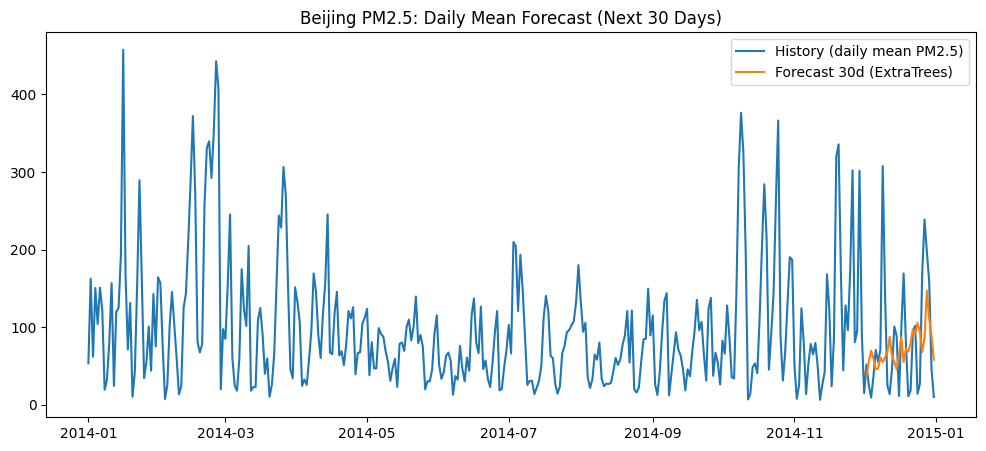

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error


# =========================
# CONFIG
# =========================
CSV_PATH = "/content/PRSA_data_2010.1.1-2014.12.31.csv"  # <-- путь к файлу
H = 30                 # горизонт прогноза (дней)
TEST_DAYS = 180        # тестовый отрезок (последние N дней)


# =========================
# 1) LOAD + BUILD DAILY
# =========================
df_raw = pd.read_csv(CSV_PATH)

required = {"year", "month", "day", "hour", "pm2.5"}
missing = required - set(df_raw.columns)
if missing:
    raise ValueError(f"Не хватает колонок: {missing}. Есть: {list(df_raw.columns)}")

# types
for c in ["year", "month", "day", "hour"]:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")
df_raw["pm2.5"] = pd.to_numeric(df_raw["pm2.5"], errors="coerce")

# datetime
df_raw["dt"] = pd.to_datetime(
    dict(year=df_raw["year"], month=df_raw["month"], day=df_raw["day"], hour=df_raw["hour"]),
    errors="coerce"
)
df_raw = df_raw.dropna(subset=["dt"]).sort_values("dt").set_index("dt")

# interpolate PM2.5 short gaps
df_raw["pm2.5"] = df_raw["pm2.5"].interpolate(method="time", limit=24)
df_raw = df_raw.dropna(subset=["pm2.5"])

# daily numeric mean
daily = df_raw.resample("1D").mean(numeric_only=True)

# daily cbwd (mode)
if "cbwd" in df_raw.columns:
    daily["cbwd"] = df_raw["cbwd"].resample("1D").agg(lambda x: x.mode().iloc[0] if len(x.mode()) else np.nan)

daily = daily.dropna(subset=["pm2.5"]).rename(columns={"pm2.5": "pm25"})

print("Daily rows:", len(daily), "Period:", daily.index.min(), "->", daily.index.max())


# =========================
# 2) FEATURE ENGINEERING
# =========================
def add_features(d: pd.DataFrame) -> pd.DataFrame:
    out = d.copy()

    # calendar
    out["dow"] = out.index.dayofweek
    out["month"] = out.index.month
    out["doy"] = out.index.dayofyear

    out["dow_sin"] = np.sin(2*np.pi*out["dow"]/7)
    out["dow_cos"] = np.cos(2*np.pi*out["dow"]/7)

    out["month_sin"] = np.sin(2*np.pi*out["month"]/12)
    out["month_cos"] = np.cos(2*np.pi*out["month"]/12)

    out["doy_sin"] = np.sin(2*np.pi*out["doy"]/365.25)
    out["doy_cos"] = np.cos(2*np.pi*out["doy"]/365.25)

    # lags (include yearly)
    for lag in [1, 2, 3, 7, 14, 28, 365]:
        out[f"pm25_lag{lag}"] = out["pm25"].shift(lag)

    # rolling
    out["pm25_roll_mean_7"] = out["pm25"].rolling(7).mean()
    out["pm25_roll_mean_14"] = out["pm25"].rolling(14).mean()
    out["pm25_roll_mean_30"] = out["pm25"].rolling(30).mean()
    out["pm25_roll_std_30"] = out["pm25"].rolling(30).std()

    # log space
    out["pm25_log"] = np.log1p(out["pm25"])
    return out

feat = add_features(daily)

# meteorology numeric cols if exist
meteo_cols = [c for c in ["TEMP", "DEWP", "PRES", "Iws", "Is", "Ir"] if c in feat.columns]
cat_cols = ["cbwd"] if "cbwd" in feat.columns else []

feature_cols_num = [
    "dow_sin","dow_cos","month_sin","month_cos","doy_sin","doy_cos",
    "pm25_lag1","pm25_lag2","pm25_lag3","pm25_lag7","pm25_lag14","pm25_lag28","pm25_lag365",
    "pm25_roll_mean_7","pm25_roll_mean_14","pm25_roll_mean_30","pm25_roll_std_30",
] + meteo_cols


# =========================
# 3) TARGETS: day+1 separate, day+2..day+30 multi
# =========================
feat["y_day1"] = feat["pm25_log"].shift(-1)
Y_multi = np.column_stack([feat["pm25_log"].shift(-k).values for k in range(2, H+1)])

X = feat[feature_cols_num + cat_cols].copy()

mask = X.notna().all(axis=1).values
mask &= np.isfinite(feat["y_day1"].values)
mask &= np.isfinite(Y_multi).all(axis=1)

X = X.loc[mask]
y_day1 = feat.loc[X.index, "y_day1"].values
Y_multi = Y_multi[mask]

# time split
if len(X) <= TEST_DAYS + 200:
    TEST_DAYS = max(120, len(X)//5)

X_train, X_test = X.iloc[:-TEST_DAYS], X.iloc[-TEST_DAYS:]
y1_train, y1_test = y_day1[:-TEST_DAYS], y_day1[-TEST_DAYS:]
Ym_train, Ym_test = Y_multi[:-TEST_DAYS], Y_multi[-TEST_DAYS:]

print("Train samples:", len(X_train), "Test samples:", len(X_test))


# =========================
# 4) PREPROCESSING
# =========================
# Для Ridge полезно масштабировать num, для деревьев не нужно, но можно оставить scaler — он не портит деревья,
# просто добавляет вычисления. Если хочешь быстрее — убери StandardScaler().
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("scaler", StandardScaler())]), feature_cols_num),
    ],
    remainder="drop"
)


# =========================
# 5) BASELINES
# =========================
def to_pm25(x_log):
    return np.expm1(x_log)

pm25_today_log = np.log1p(feat.loc[X_test.index, "pm25"].values)
baseline_day1 = pm25_today_log
baseline_multi = np.repeat(pm25_today_log.reshape(-1, 1), H-1, axis=1)


# =========================
# 6) MODELS (3 models: HGB, ExtraTrees, Ridge)
# =========================
# --- HGB ---
hgb_day1 = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", HistGradientBoostingRegressor(
        random_state=42, max_depth=5, learning_rate=0.05, max_iter=600
    ))
])

hgb_multi = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", MultiOutputRegressor(HistGradientBoostingRegressor(
        random_state=42, max_depth=6, learning_rate=0.05, max_iter=700
    )))
])

# --- ExtraTrees ---
etr_base = ExtraTreesRegressor(
    n_estimators=700, random_state=42, n_jobs=-1, min_samples_leaf=2
)

etr_day1 = Pipeline(steps=[("prep", preprocess), ("reg", etr_base)])
etr_multi = Pipeline(steps=[("prep", preprocess), ("reg", MultiOutputRegressor(etr_base))])

# --- Ridge ---
ridge_day1 = Pipeline(steps=[("prep", preprocess), ("reg", Ridge(alpha=5.0, random_state=42))])
ridge_multi = Pipeline(steps=[("prep", preprocess), ("reg", MultiOutputRegressor(Ridge(alpha=5.0, random_state=42)))])


# =========================
# 7) TRAIN + PREDICT
# =========================
models = {
    "HGB": (hgb_day1, hgb_multi),
    "ExtraTrees": (etr_day1, etr_multi),
    "Ridge": (ridge_day1, ridge_multi),
}

preds = {}

for name, (m1, mm) in models.items():
    m1.fit(X_train, y1_train)
    mm.fit(X_train, Ym_train)
    preds[name] = (m1.predict(X_test), mm.predict(X_test))


# =========================
# 8) EVALUATION + PLOTS
# =========================
def eval_day1(y_true_log, y_pred_log):
    y_true = to_pm25(y_true_log)
    y_pred = to_pm25(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    return mae, rmse

def eval_multi(Y_true_log, Y_pred_log):
    Y_true = to_pm25(Y_true_log)
    Y_pred = to_pm25(Y_pred_log)
    mae_h = np.mean(np.abs(Y_true - Y_pred), axis=0)
    rmse_h = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))
    return mae_h, rmse_h

base_mae1, base_rmse1 = eval_day1(y1_test, baseline_day1)
base_mae_h, base_rmse_h = eval_multi(Ym_test, baseline_multi)

print("\n=== BASELINE ===")
print(f"day+1  MAE={base_mae1:.2f} RMSE={base_rmse1:.2f}")
print(f"day+2..30 MAE_avg={base_mae_h.mean():.2f} RMSE_avg={base_rmse_h.mean():.2f} | MAE day+7={base_mae_h[5]:.2f} | MAE day+30={base_mae_h[-1]:.2f}")

summary = []
mae_curves = {"Baseline": base_mae_h}

print("\n=== MODELS ===")
for name, (p1, pm) in preds.items():
    mae1, rmse1 = eval_day1(y1_test, p1)
    mae_h, rmse_h = eval_multi(Ym_test, pm)
    mae_curves[name] = mae_h
    summary.append((name, mae1, rmse1, mae_h.mean(), rmse_h.mean(), mae_h[5], mae_h[-1]))
    print(f"{name:10s} day+1 MAE={mae1:.2f} RMSE={rmse1:.2f} | day+2..30 MAE_avg={mae_h.mean():.2f} RMSE_avg={rmse_h.mean():.2f} | MAE day+7={mae_h[5]:.2f} | MAE day+30={mae_h[-1]:.2f}")

# Plot MAE horizon (2..30)
plt.figure(figsize=(10,4))
x = np.arange(2, H+1)
plt.plot(x, mae_curves["Baseline"], label="Baseline MAE")
for name in models.keys():
    plt.plot(x, mae_curves[name], label=f"{name} MAE")
plt.title("MAE vs Horizon (day+2..day+30)")
plt.xlabel("Days ahead")
plt.ylabel("MAE (PM2.5)")
plt.legend()
plt.show()


# =========================
# 9) FORECAST NEXT 30 DAYS (use best model by MAE_avg)
# =========================
best_name = min(summary, key=lambda t: t[3])[0]  # lowest MAE_avg for day+2..30
print("\nBest model (by MAE_avg day+2..30):", best_name)

best_day1, best_multi = models[best_name]
# already trained above on train split; for production you'd refit on all data.
last_x_date = X.index.max()
X_last = X.loc[[last_x_date]]

f1_log = best_day1.predict(X_last)[0]
fm_log = best_multi.predict(X_last)[0]   # length 29

forecast_log = np.concatenate([[f1_log], fm_log])  # length 30
forecast = to_pm25(forecast_log)

future_idx = pd.date_range(last_x_date + pd.Timedelta(days=1), periods=H, freq="1D")
forecast_series = pd.Series(forecast, index=future_idx, name=f"pm25_forecast_30d_{best_name}")

print("\nForecast starts from:", future_idx[0].date(), "based on last feature date:", last_x_date.date())
print("Next 10 days forecast:")
print(forecast_series.head(10))

# Plot history + forecast
plt.figure(figsize=(12,5))
hist = daily["pm25"].iloc[-365:]
plt.plot(hist.index, hist.values, label="History (daily mean PM2.5)")
plt.plot(forecast_series.index, forecast_series.values, label=f"Forecast 30d ({best_name})")
plt.title("Beijing PM2.5: Daily Mean Forecast (Next 30 Days)")
plt.legend()
plt.show()
